In [1]:
from mizani.formatters import scientific_format
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import numpy as np
import pandas as pd
from plotnine import *
import skmisc
import sys
import warnings

# read in custom modules
sys.path.append('/Users/rosekantor/work/wbe_data_analysis/')
from read_gsheets import * 
from reprocess_qpcr import *
from calculations import *
from qa_qc import *
from quality_score import *

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Data tables:

In [2]:
sites = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/site_lookup_021721.csv'
samples = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/sample_inventory_021721.csv'
qpcr = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/QuantStudio_raw_data_021721.csv'
plates = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/Plate_info_021721.csv'
sample_log = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/Sample_collection_log.csv'
sample_metadata = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/Sample_metadata.csv'

In [3]:
pd.read_csv(sites).head()

,utility_name,county,utility,facility,site,sample_code,sample_level,sampling_days,sampling_frequency_per_week,site_full_name,site_description,site_pretreatment,site_population_served
0,SD5,Marin,A,A,INF,A_A_INF,Influent,Tuesday,1,Sanitary District No.5 of Marin County,NaN,NaN,NaN
1,CMSA,Marin,B,B,RV,B_B_RV,Influent,Tuesday,1,Ross Valley,NaN,NaN,NaN
2,CMSA,Marin,B,B,SD2,B_B_SD2,Influent,Tuesday,1,Sanitation district 2,NaN,NaN,NaN
3,CMSA,Marin,B,B,SQ,B_B_SQ,Residential,"Saturday,Sunday,Monday,Tuesday",4,San Quentin Prison,NaN,NaN,NaN
4,CMSA,Marin,B,B,SR,B_B_SR,Influent,Tuesday,1,San Rafael,NaN,NaN,NaN


In [4]:
pd.read_csv(samples)[1000:1005]

,sample_id,batch,sample_code,date_sampling,replicate,date_extract,extracted_by,weight,bCoV_spike_tube,GFP_spike_tube,processing_error,qPCR_batch,Storage_conditions,salted_before_freezing,date_frozen,elution_vol_ul,effective_vol_extracted_ml,weight_vol_extracted_ml,bCoV_spike_vol_ul,GFP_spike_vol_ul,time,old_sample_id,storage_notes
1000,J_J_UVASW_101420_4,NaN,J_J_UVASW,10/14/2020,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-80,1.0,10/14/20,NaN,NaN,NaN,NaN,NaN,NaN,J_J_UVASW_101420_4,NaN
1001,control_control_PBS_101520_1,R101520_1,control_control_PBS,10/15/2020,1,10/15/2020,NaN,64.99,CM,BQ,NaN,R16,NaN,NaN,NaN,200.0,40.0,41.51,50.0,20.0,NaN,control_control_PBS_101520_1,NaN
1002,D_SEP_CH_101520_1,R101620_1,D_SEP_CH,10/15/2020,1,10/16/2020,NaN,64.80,CN,BR,NaN,R17,NaN,1.0,NaN,200.0,40.0,41.32,50.0,20.0,NaN,D_SEP_CH_101520_1,NaN
1003,D_SEP_CH_101520_2,R101620_1,D_SEP_CH,10/15/2020,2,10/16/2020,NaN,64.70,CN,BR,NaN,NaN,NaN,1.0,NaN,200.0,40.0,41.22,50.0,20.0,NaN,D_SEP_CH_101520_2,NaN
1004,D_SEP_CH_101520_3,R101620_1,D_SEP_CH,10/15/2020,3,10/16/2020,NaN,65.00,CN,BR,NaN,NaN,NaN,1.0,NaN,200.0,40.0,41.52,50.0,20.0,NaN,D_SEP_CH_101520_3,NaN


In [5]:
pd.read_csv(qpcr)[10000:10005]

,Well,Omit,Sample,Target,Dye,Task,Cq,Quantity,plate_id,is_primary_value
10000,E1,False,1.00E+05,PMMoV Ultra man,FAM,Standard,25.3733261,100000.00,1096,Y
10001,F12,False,5X_F_F_INF_112320_1,PMMoV Ultra man,FAM,Unknown,28.3563962,14299.91,1096,Y
10002,F11,False,5X_F_F_INF_112320_1,PMMoV Ultra man,FAM,Unknown,28.4377607,13585.22,1096,Y
10003,F10,False,5X_F_F_INF_112320_1,PMMoV Ultra man,FAM,Unknown,28.4853181,13184.14,1096,Y
10004,F9,False,5X_M_M_INF_112420_3,PMMoV Ultra man,FAM,Unknown,27.6479219,22346.94,1096,Y


In [6]:
pd.read_csv(plates).tail()

,plate_id,plate_file_name,added pop up lab samples,plate_date,assays,standard_type,standard_batch,description,run_by,rxn_volume,template_volume,plate_notes,Standard curve by,plate by
333,1333.0,1333_N1_Routine02.13,R147,2/13/2021,N1,DNA,DNA1.1,Routine samples processed 2/13,Justin,20.0,5.0,NaN,Wall-E,Wall-E
334,1334.0,1334_PMMoV_Routine02.13,R147,2/13/2021,PMMoV,DNA,DNA1.1,Routine samples processed 2/13,Justin,20.0,5.0,NaN,Wall-E,Justin
335,1335.0,1335_bCoV_Routine02.13,R147,2/13/2021,bCoV,DNA,DNA1.1,Routine samples processed 2/13,Justin,20.0,5.0,NaN,Wall-E,Justin
336,1336.0,1336_bCoV_Routine02.16,R145,2/16/2021,bCoV,DNA,DNA1.1,Routine samples processed 2/16,Melissa,20.0,5.0,NaN,Wall-E,Melissa
337,1337.0,1337_N1_Routine02.16,R148,2/16/2021,N1,DNA,DNA1.1,Routine samples processed 2/16,Aliya,20.0,5.0,NaN,Wall-E,Aliya


In [7]:
pd.read_csv(sample_log).tail()

,Timestamp,utility_name,sample_code,time_of_sample_collection,date_sampling,Additional notes about the sample,Composite sampler log (optional),"Flow (MGD) for this location, if known",Sample_type,Number of samples composited,Number of hours represented by composite,Sample draw frequency (per hour),"Chain of custody electronic signature (please type your name in the space below, if required by your agency)"
407,1/26/2021 13:36:51,SFPUC,D_SEP_INF,9:35:00 AM,12/5/2021,Sample collected by lab and kept at 4C,NaN,NaN,Composite,96.0,24.0,4.0,Leilani Elaydo
408,1/26/2021 13:38:10,SFPUC,D_SEP_INF,9:35:00 AM,1/25/2021,Sample collected by lab and kept at 4C,NaN,NaN,Composite,24.0,24.0,1.0,Leilani Elaydo
409,1/27/2021 7:53:09,LGSD,F_F_INF,8:30:00 AM,1/26/2021,NaN,NaN,NaN,Composite,48.0,24.0,2.0,NaN
410,1/28/2021 7:46:18,USD,R_R_Alvarado,7:02:00 AM,1/28/2021,95 of 96 samples collected - An error was observed on sample 15 (No Liquid Detected)\nRain Event during sampling.,NaN,NaN,Composite,95.0,24.0,4.0,Mike Lothian
411,1/28/2021 13:46:19,LGSD,F_F_INF,8:33:00 AM,1/28/2021,NaN,NaN,NaN,Composite,48.0,24.0,2.0,NaN


In [8]:
pd.read_csv(sample_metadata).tail()

,Timestamp,utility_name,sample_code,date_sampling,TSS (mg/L) (if available),COD (mg/L) (if available),BOD (mg/L) (if available)
111,11/12/2020 12:19:53,WCWD,M_M_INF,11/12/2020,430.0,754.0,NaN
112,11/19/2020 7:59:58,WCWD,M_M_INF,11/15/2020,352.0,622.0,NaN
113,11/19/2020 8:00:35,WCWD,M_M_INF,11/17/2020,430.0,810.0,NaN
114,11/23/2020 13:28:51,WCWD,M_M_INF,11/19/2020,302.0,500.0,NaN
115,11/23/2020 13:30:11,WCWD,M_M_INF,11/22/2020,353.0,587.0,NaN


# Run processing pipeline

NOTE: errors will appear if the data is not clean.

In [9]:
# load sample log
sl = pd.read_csv(sample_log)
sl.date_sampling = pd.to_datetime(sl.date_sampling)
sl = sl.drop_duplicates(['sample_code', 'date_sampling'])
sl = sl.rename(columns={'Flow (MGD) for this location, if known': 'flow_MGD'})
sl.flow_MGD = pd.to_numeric(sl.flow_MGD)
sl = sl.drop(columns=['Timestamp', 'utility_name'])

In [10]:
#load sample metadata log
sm = pd.read_csv(sample_metadata)
sm.date_sampling = pd.to_datetime(sm.date_sampling)
sm = sm.rename(columns={'TSS (mg/L) (if available)': 'TSS',
                        'COD (mg/L) (if available)': 'COD',
                        'BOD (mg/L) (if available)': 'BOD'
                       })
sm.TSS = pd.to_numeric(sm.TSS)
sm.COD = pd.to_numeric(sm.COD)
sm.BOD = pd.to_numeric(sm.BOD)
sm = sm.drop(columns=['Timestamp', 'utility_name'])
sm = sm.drop_duplicates(['sample_code', 'date_sampling'])
sampling_df = sl.merge(sm, how='left', on=['sample_code', 'date_sampling'])

In [11]:
sampling_df.head()

,sample_code,time_of_sample_collection,date_sampling,Additional notes about the sample,Composite sampler log (optional),flow_MGD,Sample_type,Number of samples composited,Number of hours represented by composite,Sample draw frequency (per hour),"Chain of custody electronic signature (please type your name in the space below, if required by your agency)",TSS,COD,BOD
0,B_B_RV,11:57:00 PM,2020-12-15,NaN,NaN,6.51,Composite,96.0,24.0,4.0,Kunning Zhu,NaN,NaN,NaN
1,B_B_RV,11:25:00 PM,2020-12-22,NaN,NaN,5.63,Composite,96.0,24.0,4.0,Kunning Zhu,NaN,NaN,NaN
2,B_B_RV,11:44:00 PM,2020-12-29,NaN,NaN,6.40,Composite,96.0,24.0,4.0,Kunning Zhu,NaN,NaN,NaN
3,B_B_SD2,6:21:00 AM,2020-10-07,NaN,NaN,0.89,Composite,96.0,24.0,4.0,Eromosele Esoimeme,NaN,NaN,NaN
4,B_B_SD2,6:35:00 AM,2020-10-14,NaN,NaN,0.97,Composite,96.0,24.0,4.0,Eromosele Esoimeme,NaN,NaN,NaN


In [12]:
# read in plate info
plate_info_df = pd.read_csv(plates)
plate_info_df.plate_id = pd.to_numeric(plate_info_df.plate_id)
plate_info_df.plate_date = pd.to_datetime(plate_info_df.plate_date)

# drop all PMMoV standards where standard type is RNA (because these are bad), 
# Once dropped, these will automatically be replaced with the default DNA curve
# # get list of PMMoV plates with RNA standard curves that need replacing
# replace_curves = plate_info_df[(plate_info_df.assays == 'PMMoV') &
#                                (plate_info_df.standard_type == 'RNA')]['plate_id'].to_list()

In [13]:
# read and process qPCR data
plate_df_raw = read_qpcr_data(None, None, qpcr)
# remove Xeno from targets (this was an inhibition control, we no longer use)
plate_df_raw = plate_df_raw[plate_df_raw.Target != 'Xeno']

# filter out the standards from the plates that have curves that need replacing
# plates without standards are automatically assigned the default standard curve
# plate_df_raw = plate_df_raw[~((plate_df_raw.plate_id.isin(replace_curves)) &
#                               (plate_df_raw.Task == 'Standard'))]

# # replace all standard curves with default by dropping them at this step
# first catch them in a separate df
plate_standards_df = plate_df_raw[plate_df_raw.Task == 'Standard']
plate_df_raw = plate_df_raw[plate_df_raw.Task != 'Standard']

plate_df_raw.head()

,Well,Omit,sample_full,Target,Dye,Task,Cq,Quantity,plate_id,is_primary_value,dilution,Sample,is_undetermined,Target_full
6,F12,False,J_J_UVASW_082720_2,N1,FAM,Unknown,34.575077,23.43,80,Y,1,J_J_UVASW_082720_2,False,N1 IVT man
8,F11,False,J_J_UVASW_082720_2,N1,FAM,Unknown,34.535780,24.00,80,Y,1,J_J_UVASW_082720_2,False,N1 IVT man
17,E12,False,J_J_UVASW_082020_1,N1,FAM,Unknown,34.941860,18.72,80,Y,1,J_J_UVASW_082020_1,False,N1 IVT man
19,E11,False,J_J_UVASW_082020_1,N1,FAM,Unknown,34.484800,24.76,80,Y,1,J_J_UVASW_082020_1,False,N1 IVT man
28,H12,False,J_J_UVASW_091020_1,N1,FAM,Unknown,NaN,NaN,80,Y,1,J_J_UVASW_091020_1,True,N1 IVT man


In [14]:
# process the qPCR data <- the bulk of the code happens in this step
qpcr_processed_dilutions, plate_target_info = process_qpcr_plate(plate_df_raw)
qpcr_processed = choose_dilution(qpcr_processed_dilutions)

qpcr_processed.head()

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:336: UserWarning: Sample B_B_RV_020921_1 x N1 has multiple entries with the same dilution factor in plates [1324 1325]
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:336: UserWarning: Sample B_B_SQ_010221_1 x PMMoV has multiple entries with the same dilution factor in plates [1197 1310]
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:336: UserWarning: Sample B_B_SQ_010321_1 x PMMoV has multiple entries with the same dilution factor in plates [1197 1310]
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:336: UserWarning: Sample B_B_SQ_010421_1 x PMMoV has multiple entries with the same dilution factor in plates

,Sample,dilution,Task,Cq,Quantity,is_undetermined,Cq_no_outliers,Cq_init_mean,Cq_init_std,Cq_init_min,replicate_init_count,Q_init_mean,Q_init_std,Cq_mean,Cq_std,replicate_count,nondetect_count,Quantity_mean_with_dilution,below_limit_of_quantification,plate_id,Target,Quantity_mean
1,A_A_INF_010521_1,5,Unknown,"[35.37965, 36.52783, nan]","[22.74, 10.24, nan]","[False, False, True]","[35.37965, 36.52783, nan]",35.953740,0.574090,35.37965,3,15.259672,1.757947,35.953740,0.574090,2,1,3.497381,False,1195,N1,17.486906
0,A_A_INF_010521_1,5,Unknown,"[30.516740000000002, 30.38846, 30.580990000000003]","[46.86, 52.11, 44.43]","[False, False, False]","[30.516740000000002, 30.38846, 30.580990000000003]",30.495397,0.080036,30.38846,3,47.694309,1.084558,30.495397,0.080036,3,0,1971.653692,False,1197,PMMoV,9858.268462
1,A_A_INF_010521_2,5,Unknown,"[35.818259999999995, 36.15197, 36.19291]","[28.74, 23.12, 22.51]","[False, False, False]","[35.818259999999995, 36.15197, 36.19291]",36.054380,0.167797,35.81826,3,24.638638,1.143409,36.054380,0.167797,3,0,3.269931,False,1196,N1,16.349653
1,A_A_INF_011221_1,5,Unknown,"[33.91222, 34.40655, 34.05749]","[36.69, 26.78, 33.45]","[False, False, False]","[33.91222, 34.40655, 34.05749]",34.125420,0.207447,33.91222,3,32.032055,1.175663,34.125420,0.207447,3,0,11.865829,False,1214,N1,59.329145
0,A_A_INF_011221_1,5,Unknown,"[27.49398, 27.41733, 27.556859999999997]","[11252.21, 11840.93, 10791.19]","[False, False, False]","[27.49398, 27.41733, 27.556859999999997]",27.489390,0.057055,27.41733,3,11286.631015,1.047589,27.489390,0.057055,3,0,13863.517564,False,1216,PMMoV,69317.587822


In [15]:
# process just the standards (if they have been removed from the data)

with warnings.catch_warnings(): # ignore warnings that there are no NTCs, this cell only runs standards
    warnings.simplefilter("ignore")
    qpcr_processed_dilutions_stds, plate_target_info_stds = process_qpcr_plate(plate_standards_df)

In [16]:
# make plate_target_info table by merging plate data table with plate data that comes from process_qpcr_plate
plate_target_info_stds = plate_target_info_stds.merge(plate_info_df, how = 'left', on = 'plate_id')
# fill in default values
plate_target_info_stds.loc[plate_target_info_stds.rxn_volume.isna(), 'rxn_volume'] = 20.0
plate_target_info_stds.loc[plate_target_info_stds.template_volume.isna(), 'template_volume'] = 5.0

# intraassay variation is only calculated for plates with samples, so the dataframe containing just standards will not have this
# (code was initially designed to keep standards and samples together, but we are splitting them now to force use of default standard curves)
# merge intraassay_var back into plate_target_info dataframe
plate_target_info_stds = plate_target_info_stds.drop(columns='intraassay_var')
plate_target_info_stds = plate_target_info_stds.merge(plate_target_info[['intraassay_var', 'plate_id', 'Target']], how = 'left', on = ['plate_id', 'Target'])

plate_target_info_stds.head()

,num_points,slope,intercept,r2,efficiency,loq_Cq,loq_Quantity,used_default_curve,plate_id,Target,Cq_of_lowest_sample_quantity,ntc_is_neg,ntc_Cq,Target_full,plate_file_name,added pop up lab samples,plate_date,assays,standard_type,standard_batch,description,run_by,rxn_volume,template_volume,plate_notes,Standard curve by,plate by,intraassay_var
0,6,-3.727214,39.602169,0.998739,0.854799,35.526558,10.0,False,80,N1,NaN,None,NaN,[N1 IVT man],NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,20.0,5.0,NaN,NaN,NaN,52.773852
1,7,-3.716195,45.981926,0.998214,0.858200,38.141236,100.0,False,1001,PMMoV,NaN,None,NaN,[PMMoV Ultra man],R1_PMMoV_Test,Batch R1,2020-09-18,PMMoV,RNA,NaN,Melissa's first plate,Melissa,20.0,5.0,previously called R1,NaN,NaN,15.630454
2,6,-3.569281,38.339096,0.996088,0.906200,34.682458,10.0,False,1002,N1,NaN,None,NaN,[N1 IVT man],R2_N1_RoutineSample9.21,Batch R2,2020-09-21,"N1, xeno",RNA,1.1,High priority processed fresh,Melissa,20.0,5.0,previously called R2,NaN,NaN,223.693502
3,7,-3.716783,46.268504,0.996343,0.858018,38.043897,100.0,False,1003,PMMoV,NaN,None,NaN,[PMMoV Ultra man],R3_PMMoV_RoutineSample9.21,Batch R2,2020-09-21,PMMoV,RNA,NaN,High priority processed fresh,Melissa,20.0,5.0,previously called R3,NaN,NaN,8.763514
4,7,-3.465195,41.877310,0.999843,0.943498,27.919310,10000.0,False,1004,GFP,NaN,None,NaN,[GFP IVT man],R4_GFP_Routine9.22,some of batch R2 + spikes,2020-09-22,GFP,RNA,NaN,Adrian training plate,Adrian,20.0,5.0,previously called R4,NaN,NaN,5.195485


In [17]:
# merge with sample data and plate_target info
# merging is dangerous, extra rows can be introduced if the merge isn't exact (e.g. multiple identical entries- see warnings)
sample_data = read_sample_data(None, None, samples, sites)
sample_data_qpcr = qpcr_processed.merge(sample_data, how = 'left', left_on = 'Sample', right_on = 'sample_id')
sample_data_qpcr = sample_data_qpcr.merge(plate_target_info_stds, how = 'left', on = ['plate_id', 'Target'])

sample_data_qpcr.head()

/Users/rosekantor/work/wbe_data_analysis/read_gsheets.py:74: UserWarning: 1 samples are double listed in sample tracking spreadsheet. Check the following samples: [nan]


,Sample,dilution,Task,Cq,Quantity,is_undetermined,Cq_no_outliers,Cq_init_mean,Cq_init_std,Cq_init_min,replicate_init_count,Q_init_mean,Q_init_std,Cq_mean,Cq_std,replicate_count,nondetect_count,Quantity_mean_with_dilution,below_limit_of_quantification,plate_id,Target,Quantity_mean,sample_id,batch,sample_code,date_sampling,replicate,date_extract,extracted_by,weight,bCoV_spike_tube,GFP_spike_tube,processing_error,qPCR_batch,Storage_conditions,salted_before_freezing,date_frozen,elution_vol_ul,effective_vol_extracted_ml,weight_vol_extracted_ml,bCoV_spike_vol_ul,GFP_spike_vol_ul,time,old_sample_id,storage_notes,utility_name,county,utility,facility,site,sample_level,sampling_days,sampling_frequency_per_week,site_full_name,site_description,site_pretreatment,site_population_served,num_points,slope,intercept,r2,efficiency,loq_Cq,loq_Quantity,used_default_curve,Cq_of_lowest_sample_quantity,ntc_is_neg,ntc_Cq,Target_full,plate_file_name,added pop up lab samples,plate_date,assays,standard_type,standard_batch,description,run_by,rxn_volume,template_volume,plate_notes,Standard curve by,plate by,intraassay_var
0,A_A_INF_010521_1,5,Unknown,"[35.37965, 36.52783, nan]","[22.74, 10.24, nan]","[False, False, True]","[35.37965, 36.52783, nan]",35.953740,0.574090,35.37965,3,15.259672,1.757947,35.953740,0.574090,2,1,3.497381,False,1195,N1,17.486906,A_A_INF_010521_1,R010621_1,A_A_INF,2021-01-05,1,2021-01-06,Melissa,NaN,HF,FW,NaN,NaN,NaN,NaN,NaN,200.0,40.0,40.000,50.0,20.0,NaN,A_A_INF_010521_1,NaN,SD5,Marin,A,A,INF,Influent,Tuesday,1.0,Sanitary District No.5 of Marin County,NaN,NaN,NaN,7,-3.314337,39.876264,0.995823,1.003178,36.945277,5.0,False,NaN,None,NaN,[N1 IVT Luna],1195_N1_Routine01.07,R103,2021-01-07,N1,DNA,DNA1.1,Routine samples processed 01/07,Justin,20.0,5.0,NaN,Wall-E,Wall-E,28.519417
1,A_A_INF_010521_1,5,Unknown,"[30.516740000000002, 30.38846, 30.580990000000003]","[46.86, 52.11, 44.43]","[False, False, False]","[30.516740000000002, 30.38846, 30.580990000000003]",30.495397,0.080036,30.38846,3,47.694309,1.084558,30.495397,0.080036,3,0,1971.653692,False,1197,PMMoV,9858.268462,A_A_INF_010521_1,R010621_1,A_A_INF,2021-01-05,1,2021-01-06,Melissa,NaN,HF,FW,NaN,NaN,NaN,NaN,NaN,200.0,40.0,40.000,50.0,20.0,NaN,A_A_INF_010521_1,NaN,SD5,Marin,A,A,INF,Influent,Tuesday,1.0,Sanitary District No.5 of Marin County,NaN,NaN,NaN,6,-3.548825,42.188174,0.955994,1.269040,30.632130,100.0,True,NaN,None,NaN,[PMMoV Ultra Luna],1197_PMMoV_Routine01.07,R103,2021-01-07,PMMoV,DNA,DNA1.1,Routine samples processed 01/07,Justin,20.0,5.0,NaN,Wall-E,Wall-E,38.483814
2,A_A_INF_010521_2,5,Unknown,"[35.818259999999995, 36.15197, 36.19291]","[28.74, 23.12, 22.51]","[False, False, False]","[35.818259999999995, 36.15197, 36.19291]",36.054380,0.167797,35.81826,3,24.638638,1.143409,36.054380,0.167797,3,0,3.269931,False,1196,N1,16.349653,A_A_INF_010521_2,R010621_1,A_A_INF,2021-01-05,2,2021-01-06,Melissa,NaN,HF,FW,NaN,NaN,NaN,NaN,NaN,200.0,40.0,40.000,50.0,20.0,NaN,A_A_INF_010521_2,NaN,SD5,Marin,A,A,INF,Influent,Tuesday,1.0,Sanitary District No.5 of Marin County,NaN,NaN,NaN,5,-3.510248,40.882269,0.998424,0.926993,38.674700,5.0,False,NaN,None,NaN,[N1 IVT Luna],1196_N1_Routine01.07,R103,2021-01-07,N1,DNA,DNA1.1,Routine samples processed 01/07,Justin,20.0,5.0,NaN,Wall-E,Justin,29.801623
3,A_A_INF_011221_1,5,Unknown,"[33.91222, 34.40655, 34.05749]","[36.69, 26.78, 33.45]","[False, False, False]","[33.91222, 34.40655, 34.05749]",34.125420,0.207447,33.91222,3,32.032055,1.175663,34.125420,0.207447,3,0,11.865829,False,1214,N1,59.329145,A_A_INF_011221_1,R011321_1,A_A_INF,2021-01-12,1,2021-01-13,Melissa,64.7,HK,GB,NaN,NaN,NaN,NaN,NaN,200.0,40.0,41.215,50.0,20.0,NaN,A_A_INF_011221_1,NaN,SD5,Marin,A,A,INF,Influent,Tuesday,1.0,Sanitary District No.5 of Marin County,NaN,NaN,NaN,7,-3.613744,39.566220,0.995214,0.891130,37.828610,5.0,False,NaN,None,NaN,[N1 IVT Luna],1214_N1_Routine01.13,R107,2021-01-13,N1,DNA,DNA1.1,Routine samples processed 1/13,Justin,20.0,5.0,NaN,Wall-E,Wall-E,24.629961
4,A_A_INF_0112

In [18]:
# QA/QC

# pull out extraction controls and report them for each batch
sample_data_qpcr = get_extraction_control(sample_data_qpcr)

# add quality scores
quality_scores = quality_score(sample_data_qpcr)
sample_data_qpcr = sample_data_qpcr.merge(quality_scores, how='left', on=['Sample', 'Target', 'plate_id'])

quality_scores.head()

,Sample,Target,plate_id,score,flag,point_deduction,quality_score
0,D_OSP_INF_010321_1,N1,1189,0.562,NaN,r2 ok; no-template qPCR control amplified,82.647059
1,D_SEP_INF_010321_1,N1,1189,0.562,NaN,r2 ok; no-template qPCR control amplified,82.647059
2,K_K_INF_010321_1,N1,1189,0.562,NaN,r2 ok; no-template qPCR control amplified,82.647059
3,K_K_INF_010421_1,N1,1189,0.562,NaN,r2 ok; no-template qPCR control amplified,82.647059
4,M_M_INF_010321_1,N1,1189,0.562,NaN,r2 ok; no-template qPCR control amplified,82.647059


In [19]:
# Calculations: calculate gc/L and N1:PMMoV
sample_data_qpcr['gc_per_mL'] = calculate_gc_per_ml(sample_data_qpcr)
sample_data_qpcr = normalize_to_pmmov(sample_data_qpcr)

# make column listing number of technical replicates detected, based on the non-detect count
sample_data_qpcr['detected_of_3_TechReps'] = 3 - sample_data_qpcr['nondetect_count']

# merge with metadata
sample_data_qpcr = sample_data_qpcr.merge(sampling_df, how='left', on=['sample_code', 'date_sampling'])

# abbreviate site names for plotting
sample_data_qpcr.site_full_name = sample_data_qpcr.site_full_name.str.replace(r'[Ss]anitary [Dd]istrict|[Ss]anitation [Dd]istrict|[Ss]ervices [Dd]istrict', 'SD')

# filter out controls and samples without a county
sample_data_qpcr = sample_data_qpcr[~sample_data_qpcr.county.isna()].copy()
sample_data_qpcr = sample_data_qpcr[~sample_data_qpcr.county.str.contains('control')].copy() # these filters can't be in the same line or pandas freaks#Save this table

#sample_data_qpcr[sample_data_qpcr.Target.isin(['N1', 'PMMoV'])][['Sample', 'sample_code', 'replicate', 'quality_score', 'gc_per_mL', 'Target']].to_csv('data.csv', index=False)

In [20]:
# Final table:
sample_data_qpcr.head()

,Sample,dilution,Task,Cq,Quantity,is_undetermined,Cq_no_outliers,Cq_init_mean,Cq_init_std,Cq_init_min,replicate_init_count,Q_init_mean,Q_init_std,Cq_mean,Cq_std,replicate_count,nondetect_count,Quantity_mean_with_dilution,below_limit_of_quantification,plate_id,Target,Quantity_mean,sample_id,batch,sample_code,date_sampling,replicate,date_extract,extracted_by,weight,bCoV_spike_tube,GFP_spike_tube,processing_error,qPCR_batch,Storage_conditions,salted_before_freezing,date_frozen,elution_vol_ul,effective_vol_extracted_ml,weight_vol_extracted_ml,bCoV_spike_vol_ul,GFP_spike_vol_ul,time,old_sample_id,storage_notes,utility_name,county,utility,facility,site,sample_level,sampling_days,sampling_frequency_per_week,site_full_name,site_description,site_pretreatment,site_population_served,num_points,slope,intercept,r2,efficiency,loq_Cq,loq_Quantity,used_default_curve,Cq_of_lowest_sample_quantity,ntc_is_neg,ntc_Cq,Target_full,plate_file_name,added pop up lab samples,plate_date,assays,standard_type,standard_batch,description,run_by,rxn_volume,template_volume,plate_notes,Standard curve by,plate by,intraassay_var,extraction_control_is_neg,extraction_control_Cq,score,flag,point_deduction,quality_score,gc_per_ul_input,gc_per_mL,pmmov_mean,mean_normalized_to_pmmov,log10mean_normalized_to_log10pmmov,log10_mean_normalized_to_pmmov,detected_of_3_TechReps,time_of_sample_collection,Additional notes about the sample,Composite sampler log (optional),flow_MGD,Sample_type,Number of samples composited,Number of hours represented by composite,Sample draw frequency (per hour),"Chain of custody electronic signature (please type your name in the space below, if required by your agency)",TSS,COD,BOD
0,D_OSP_INF_010321_1,5,Unknown,"[34.06278820000001, 33.0009499, 33.765113]","[34.34, 69.67, 41.87]","[False, False, False]","[34.06278820000001, 33.0009499, 33.765113]",33.609617,0.447221,33.000950,3,46.442582,1.440428,33.609617,0.447221,3,0,16.748562,False,1189,N1,83.742810,D_OSP_INF_010321_1,R010521_1,D_OSP_INF,2021-01-03,1,2021-01-05,Matt,63.7,HD,FU,NaN,NaN,NaN,NaN,NaN,200.0,40.0,40.215,50.0,20.0,NaN,D_OSP_INF_010321_1,NaN,SFPUC,SF,D,OSP,INF,Influent,Tuesday,2.0,Oceanside Treatment Plant,Oceanside Treatment Plant Influent (western half of San Francisco) and is not chlorinated,NaN,NaN,7,-3.456707,39.371722,0.954329,0.946672,36.542137,5.0,False,NaN,None,NaN,[N1 IVT Luna],1189_N1_Routine01.05,R101,2021-01-05,N1,DNA,DNA1.1,Routine samples processed 01/05,Melissa,20.0,5.0,NaN,Wall-E,Melissa,19.372989,True,NaN,0.562,NaN,r2 ok; no-template qPCR control amplified,82.647059,16.748562,83.295098,118548.043300,0.000706,0.378988,-3.150947,3,9:30:00 AM,NaN,NaN,13.80,Composite,24.0,24.0,1.00,Leilani Elaydo,NaN,NaN,NaN
1,D_SEP_INF_010321_1,5,Unknown,"[33.825411700000004, 34.088310899999996, 34.510592700000004]","[40.23, 33.76, 25.49]","[False, False, False]","[33.825411700000004, 34.088310899999996, 34.510592700000004]",34.141438,0.282235,33.825412,3,32.591732,1.258843,34.141438,0.282235,3,0,11.739504,False,1189,N1,58.697519,D_SEP_INF_010321_1,R010521_1,D_SEP_INF,2021-01-03,1,2021-01-05,Matt,64.7,HD,FU,NaN,NaN,NaN,NaN,NaN,200.0,40.0,41.215,50.0,20.0,NaN,D_SEP_INF_010321_1,NaN,SFPUC,SF,D,SEP,INF,Influent,Tuesday,3.0,Southeast Treatment Plant,Southeast Treatment Plant Influent (eastern half of San Francisco) This will be labeled as SEP_RAW and is chlorinated,chlorine,NaN,7,-3.456707,39.371722,0.954329,0.946672,36.542137,5.0,False,NaN,None,NaN,[N1 IVT Luna],1189_N1_Routine01.05,R101,2021-01-05,N1,DNA,DNA1.1,Routine samples processed 01/05,Melissa,20.0,5.0,NaN,Wall-E,Melissa,19.372989,True,NaN,0.562,NaN,r2 ok; no-template qPCR control amplified,82.647059,11.739504,56.967142,74313.542017,0.000790,0.363087,-3.102448,3,10:00:00 AM,NaN,NaN,46.60,Composite,24.0,24.0,1.00,Leilani Elaydo,NaN,NaN,NaN
2,K_K_INF_010321_1,5,Unknown,"[33.8239321, 33.694075899999994, 34.14599260000001]","[40.27, 43.9, 32.49]","[False, False, False]","[33.8239321, 33.694075899999994, 34.14599260000001]",33.888000,0.1

In [21]:
sample_data_qpcr.tail()[['Sample', 'dilution', 'Quantity_mean', 'Quantity_mean_with_dilution', 
                         'run_by', 'Target', 'quality_score', 'flag']]

,Sample,dilution,Quantity_mean,Quantity_mean_with_dilution,run_by,Target,quality_score,flag
3064,Q_Q_CMF_122920_2,5,60836.594819,12167.318964,Melissa,PMMoV,70.588235,NaN
3066,J_J_Kerr_111120_1,5,494996.444821,98999.288964,Justin,PMMoV,82.352941,NaN
3067,J_J_Kerr_111120_2,1,275117.339179,275117.339179,Justin,PMMoV,82.352941,NaN
3068,J_J_Kerr_111120_3,5,537003.564782,107400.712956,Justin,PMMoV,82.352941,NaN
3070,J_J_Kerr_111120_1,1,27706.699717,27706.699717,Melissa,bCoV,70.588235,NaN


# Data analysis and visualization

## Plot processed data with biological replicates

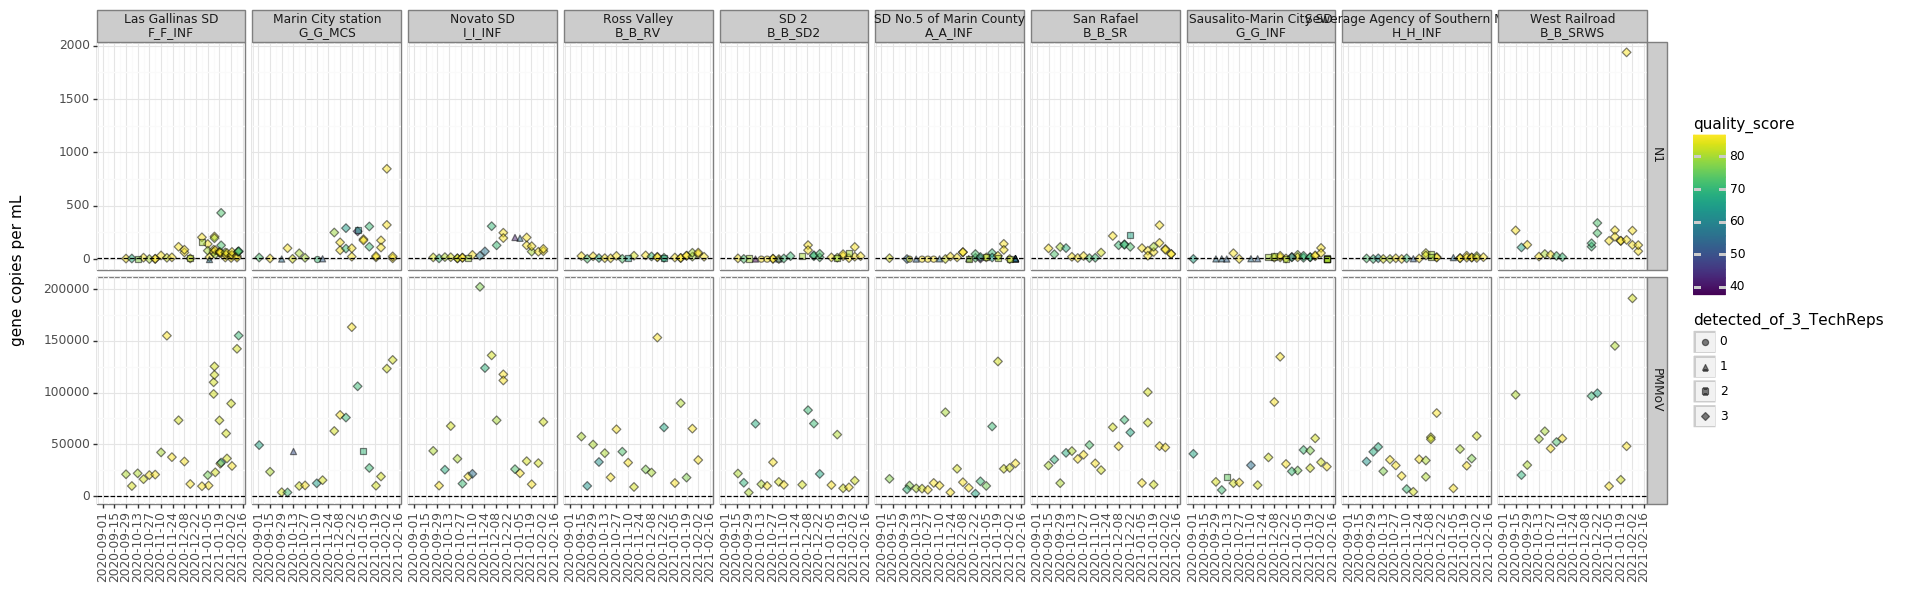

<ggplot: (298997213)>

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


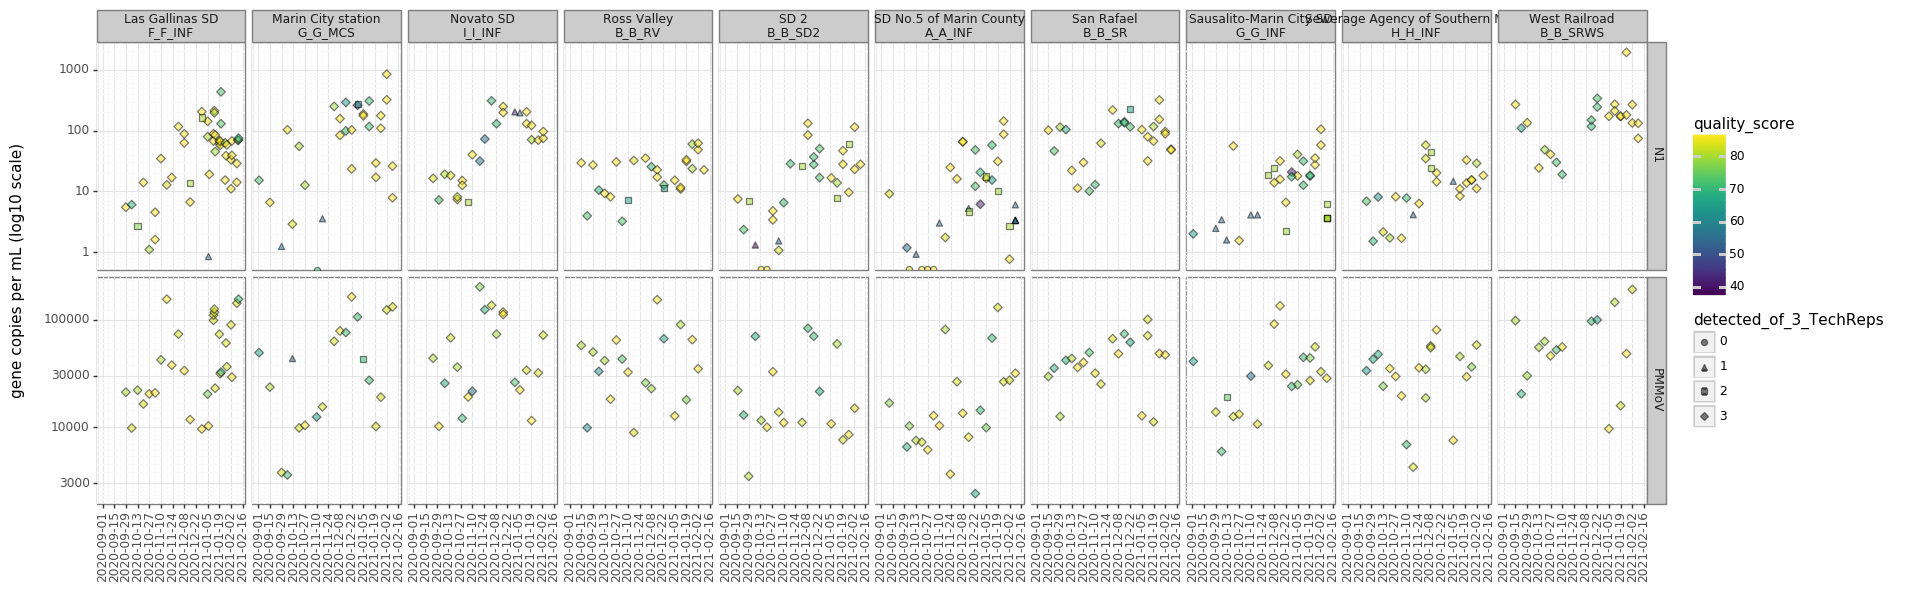

<ggplot: (303027745)>

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


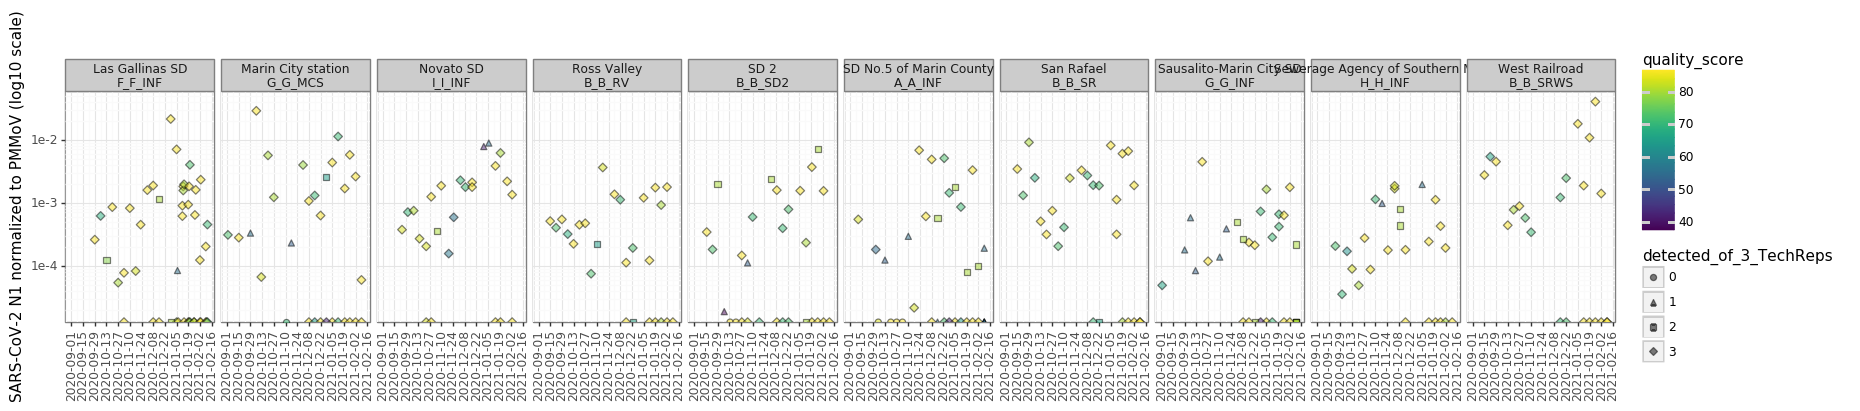

<ggplot: (303213233)>

In [22]:
# plot non-aggregated data
df_filtered = sample_data_qpcr[(sample_data_qpcr.county == 'Marin') & (sample_data_qpcr.sample_level != 'Residential')].copy()
df_filtered.loc[df_filtered.gc_per_mL.isna(), 'gc_per_mL'] = 0  
df_filtered.loc[df_filtered.mean_normalized_to_pmmov.isna(), 'mean_normalized_to_pmmov'] = 0

# convert to categorical for plotting as shape
df_filtered.detected_of_3_TechReps = df_filtered.detected_of_3_TechReps.astype('category')

#determine number of sample sites and days for setting the plot size automatically
sample_sites = len(df_filtered.site_full_name.unique())
days = (df_filtered.date_sampling.max() - df_filtered.date_sampling.min()).days

if days < 7: # make wider to avoid really narrow plots
    days = 7

width = (1.5*(days/7) * (sample_sites / 4.25)) + 5 # add 5 for legend and y-axis labels

# filter to make dataframes of just N1 and N1+PMMoV
df_N1 = df_filtered[df_filtered.Target == 'N1'].copy()
df_N1_pmmov = df_filtered[df_filtered.Target.isin(['N1', 'PMMoV'])].copy()

# get list of sample dates so that x-axis tick marks will be those dates
dates = df_N1.date_sampling.unique()

plt1 = (ggplot(df_N1_pmmov, aes(x='date_sampling', y='gc_per_mL', fill='quality_score', shape='detected_of_3_TechReps')) +
      geom_point(size=2, alpha=0.5)+
      geom_abline(slope=0, intercept=10, linetype='dashed')+
      ylab('gene copies per mL\n\n')+
      xlab("")+
      #xlim(dates.min(), dates.max())+
      scale_x_datetime(breaks = '2 week')+
      facet_grid('Target ~ site_full_name + sample_code', scales='free_y')+
      theme_bw()+ theme(axis_text_x=element_text(rotation=90, hjust=1.1), figure_size=(20,6)) ) #figure_size=(width,7)

display(plt1)

plt2 = (ggplot(df_N1_pmmov, aes(x='date_sampling', y='gc_per_mL', fill='quality_score', shape='detected_of_3_TechReps')) + 
      geom_point(size=2, alpha=0.5)+
      geom_abline(slope=0, intercept=10, linetype='dashed')+
      ylab('gene copies per mL (log10 scale)\n\n')+
      xlab("")+
      #xlim(dates.min(), dates.max())+
      scale_x_datetime(breaks = '2 week')+
      scale_y_log10()+
      facet_grid('Target ~ site_full_name + sample_code', scales='free_y')+ #, 
      theme_bw()+ theme(axis_text_x=element_text(rotation=90, hjust=1.1), figure_size=(20,6)) )

display(plt2)

plt3 = (ggplot(df_N1, aes(x='date_sampling', y='mean_normalized_to_pmmov', fill='quality_score', shape='detected_of_3_TechReps')) + 
      geom_point(size=2, alpha = 0.5)+
      geom_abline(slope=0, intercept=0)+
      ylab('SARS-CoV-2 N1 normalized to PMMoV (log10 scale)')+
      xlab("")+
      #xlim(dates.min(), dates.max())+
      scale_x_datetime(breaks = '2 week')+
      scale_y_log10()+
      facet_grid('~ site_full_name + sample_code', scales='free_y')+ #, 
      theme_bw()+ theme(axis_text_x=element_text(rotation=90, hjust=1.1), figure_size=(20,3)) )

display(plt3)

## Plot data with biological replicates aggregated

In [23]:
# Aggregate data and get geometric means of biological replicates

df_agg = sample_data_qpcr[sample_data_qpcr.Target.isin(['N1', 'PMMoV'])].copy()
df_agg = df_agg[df_agg.date_sampling > '2020-08-01']
df_agg = df_agg.groupby(['sample_code', 'date_sampling', 'Target', 'sample_level', 'county', 'site_full_name', 'utility_name']).agg(lambda x: x.tolist()).reset_index()
df_agg['gmean_gc_per_mL'] = df_agg.gc_per_mL.apply(lambda x: get_gmean(x))
df_agg['gstd_gc_per_mL'] = df_agg.gc_per_mL.apply(lambda x: get_gstd(x))
df_agg['gmean_N1_per_PMMoV'] = df_agg.mean_normalized_to_pmmov.apply(lambda x: get_gmean(x))
df_agg['gstd_N1_per_PMMoV'] = df_agg.mean_normalized_to_pmmov.apply(lambda x: get_gstd(x))

df_agg['flow_MGD_value'] = df_agg.flow_MGD.apply(np.nanmean)

df_agg['gmean_gc_per_mL_upper'] = df_agg.gmean_gc_per_mL * df_agg.gstd_gc_per_mL
df_agg['gmean_gc_per_mL_lower'] = df_agg.gmean_gc_per_mL / df_agg.gstd_gc_per_mL

df_agg['gmean_N1_per_PMMoV_upper'] = df_agg.gmean_N1_per_PMMoV * df_agg.gstd_N1_per_PMMoV
df_agg['gmean_N1_per_PMMoV_lower'] = df_agg.gmean_N1_per_PMMoV / df_agg.gstd_N1_per_PMMoV

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/core/series.py:4200: RuntimeWarning: Mean of empty slice


/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 206 rows containing missing values.


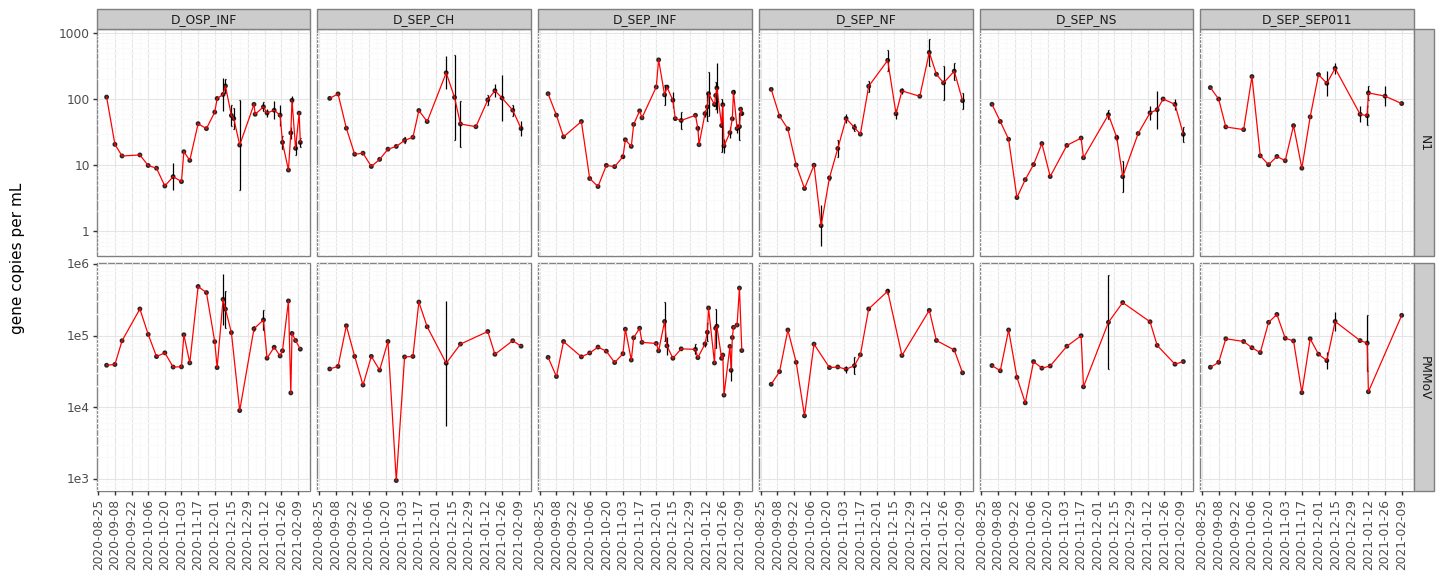

<ggplot: (301880921)>

In [24]:
# filter on one county and make example plot
df_agg_filtered =  df_agg[(df_agg.county == 'SF') & (df_agg.sample_level != 'Residential')].copy()
# fill NaNs with zero so these samples still show up in the plots
df_agg_filtered.loc[df_agg_filtered.gmean_gc_per_mL.isna(), 'gmean_gc_per_mL'] = 0

plt = (ggplot(df_agg_filtered, aes(x='date_sampling', y='gmean_gc_per_mL')) +
geom_point(size=1, alpha=0.75)+
geom_errorbar(aes(ymin='gmean_gc_per_mL_lower', ymax='gmean_gc_per_mL_upper'))+
geom_line(color='red')+
#geom_smooth(method='loess', span=0.5, se=False, linetype='dashed', color='gray', size=0.5)+
geom_abline(slope=0, intercept=10, linetype='dashed')+
ylab('gene copies per mL\n\n')+
xlab("")+
scale_y_log10()+
scale_x_datetime(breaks = '2 week')+
facet_grid('Target ~ sample_code', scales='free_y')+ #, 
theme_bw()+ theme(axis_text_x=element_text(rotation=90, hjust=1.1), figure_size=(17,6)) )

display(plt)

## Plot heatmaps

In [26]:
df = sample_data_qpcr[(sample_data_qpcr.sample_level != 'Residential') ].copy()
df['week'] = df.date_sampling.dt.strftime('%Y-%W') # create a "week" column for collapsing on
dfN1 = df[df.Target == 'N1']
dfPMMoV = df[df.Target == 'PMMoV']

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less


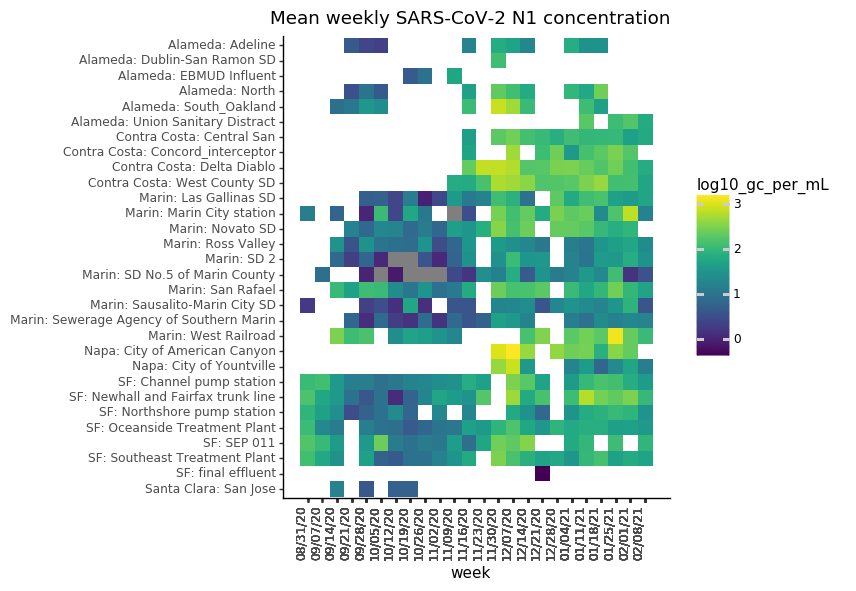

<ggplot: (301852637)>

In [27]:
# average data by week for each location
# collapse to week by converting the week to a string, and aggregating on it, then convert string back to date (monday of each week)

## GET N1 DATAFRAME COLLAPSED BY WEEK
dfN1_week = dfN1.groupby(['sample_code', 'site_full_name', 'county', 'week']).agg(
                                                                         mean_gc_per_mL=('gc_per_mL', 'mean'),
                                                                         mean_N1_per_PMMoV=('mean_normalized_to_pmmov', 'mean')
                                                                        ).reset_index()

dfN1_week['week'] = dfN1_week.week.apply(lambda x: datetime.strptime(x + '-1', "%Y-%W-%w"))

# get nice names for y-axis and sort so they appear in order
dfN1_week['county_site'] = dfN1_week[['county', 'site_full_name']].apply(lambda x: ': '.join(x), axis=1)
dfN1_week = dfN1_week.sort_values(['county', 'site_full_name'])

# order y-axis (geom_tile always reverses the order)
dfN1_week.county_site = dfN1_week.county_site.astype('category')
dfN1_week.county_site = pd.Categorical(dfN1_week.county_site,
                                      categories=dfN1_week.county_site.unique().tolist()[::-1], ordered=True)

# get log10 values so we can plot them in log10 scale
dfN1_week['log10_gc_per_mL'] = np.log10(dfN1_week.mean_gc_per_mL)
dfN1_week['log10_mean_N1_per_PMMoV'] = np.log10(dfN1_week.mean_N1_per_PMMoV)

# plot
plt = (ggplot(dfN1_week, aes(x='week', y='county_site', fill='log10_gc_per_mL'))+ #y='site_full_name # change to this if faceting by county works
 geom_tile()+
 theme_classic()+
 scale_x_datetime(breaks = dfN1_week.week, labels = date_format('%D'))+
 ylab('')+
 #facet_grid('county ~', scales='free_y', space='free_y')+ #not yet implemented in plotnine
 theme(axis_text_x=element_text(rotation=90, hjust=1), figure_size=(5, 6))+
 ggtitle('Mean weekly SARS-CoV-2 N1 concentration'))

display(plt)

## Normalize SARS-CoV-2 N1 signal to flow and chemical parameters

In [28]:
n1 = sample_data_qpcr[sample_data_qpcr.Target == 'N1'].copy()
n1['N1_per_TSS'] = n1.gc_per_mL / n1.TSS
n1['N1_per_COD'] = n1.gc_per_mL / n1.COD
n1['N1_per_BOD'] = n1.gc_per_mL / n1.BOD
n1['N1_per_flow'] = n1.gc_per_mL / n1.flow_MGD

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/facets/facet.py:552: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 84 rows containing missing values.


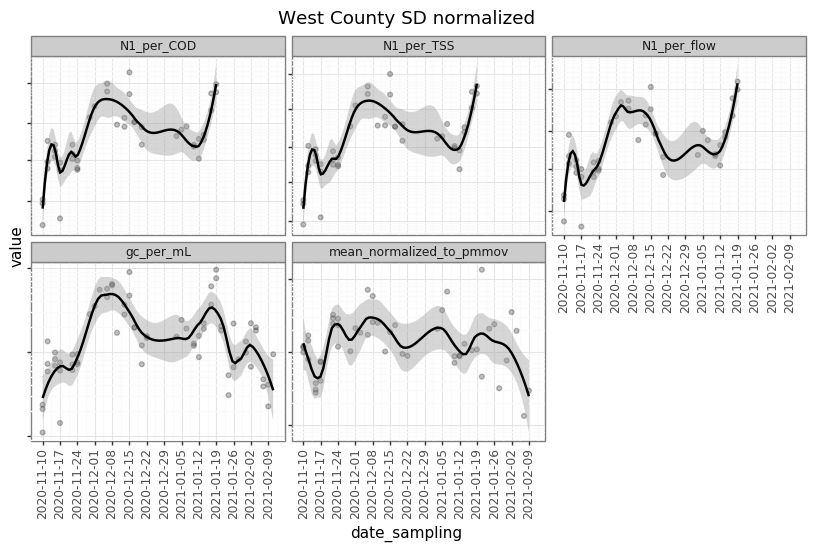

<ggplot: (300028797)>

In [29]:
wc = n1[n1.site_full_name == 'West County SD'][['date_sampling', 'gc_per_mL', 'N1_per_TSS', 'N1_per_COD', 'N1_per_flow', 'mean_normalized_to_pmmov']]
wc = wc.melt(id_vars='date_sampling', var_name='metric')

(ggplot(wc, aes(x='date_sampling', y='value'))+ #, color='metric'
geom_point(size=1.5, alpha=0.25)+
geom_smooth(method='loess', span=0.3)+
theme_bw()+
ggtitle('West County SD normalized')+
scale_y_log10()+
scale_x_datetime(breaks = '1 week')+
theme(axis_text_x=element_text(angle=90, hjust=1.1), axis_text_y=element_blank(), figure_size=(10, 5))+
facet_wrap('~ metric', scales='free_y'))